
 # Smart Crop Advisory System (SCAS) - Model Training Notebook

 **Author:** Abhay Maurya  
 **Project:** Smart Crop Advisory System (AgriMitra/Krishi.ai)  
 **Goal:** Build a multi-class classification model to recommend the most suitable crop based on soil and weather conditions.

 **Dataset Features:**
 * **N**: Ratio of Nitrogen content in soil
 * **P**: Ratio of Phosphorous content in soil
 * **K**: Ratio of Potassium content in soil
 * **temperature**: Temperature in degree Celsius
 * **humidity**: Relative humidity in %
 * **ph**: pH value of the soil
 * **rainfall**: Rainfall in mm
 * **label**: The target crop (22 classes typically)



 ## 1. Introduction & Setup
Importing necessary libraries for data manipulation, visualization, model training, and explainability.



In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
# Sklearn for metrics and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [138]:
# XGBoost
import xgboost as xgb

# Model Saving
import joblib


In [139]:
# Explainability
try:
    import shap
except ImportError:
    print("SHAP not installed. Please run '!pip install shap' if needed.")

# Plot styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings('ignore')

print("Libraries Imported Successfully.")

Libraries Imported Successfully.


## 2. Load Dataset
 Loading the agricultural data and performing initial inspection.



In [140]:
# Load Data
df = pd.read_csv('north_india_crops_augmented.csv')

In [141]:
# Display first 5 rows
print("First 5 rows:")
display(df.head())

# Info and Summary Stats
print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
display(df.describe())

First 5 rows:


,N,P,K,temperature,humidity,ph,rainfall,label
0,55.451049,34.759023,68.474255,22.055635,77.501063,6.963747,796.866368,almond
1,65.487804,35.366590,51.400261,16.546457,82.125037,6.499078,719.580897,almond
2,60.034090,33.827064,50.564195,18.878279,63.595961,7.150979,730.626227,almond
3,67.035540,38.268171,54.173506,19.991211,76.113196,7.507708,812.872838,almond
4,67.861981,35.337592,73.738320,24.680909,86.299608,6.659872,718.605649,almond



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30530 entries, 0 to 30529
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            30530 non-null  float64
 1   P            30530 non-null  float64
 2   K            30530 non-null  float64
 3   temperature  30530 non-null  float64
 4   humidity     30530 non-null  float64
 5   ph           30530 non-null  float64
 6   rainfall     30530 non-null  float64
 7   label        30530 non-null  object 
dtypes: float64(7), object(1)
memory usage: 1.9+ MB
None

Summary Statistics:


,N,P,K,temperature,humidity,ph,rainfall
count,30530.000000,30530.000000,30530.000000,30530.000000,30530.000000,30530.000000,30530.000000
mean,67.318959,49.229495,53.992459,24.624678,73.534671,6.264561,604.738930
std,37.817408,20.130845,40.141726,5.624915,15.386077,0.784655,527.626778
min,0.000000,0.000000,0.000000,0.008489,0.241239,3.504752,0.000000
25%,42.146217,39.278988,24.000000,20.891188,65.135813,5.620000,107.413725
50%,60.453968,45.753459,45.000000,25.460000,78.953720,6.344240,579.750000
75%,89.894356,60.000000,71.171207,28.500000,83.621437,6.738652,888.613421
max,194.789434,150.000000,500.000000,46.732778,99.748924,9.983822,3322.060000


In [142]:
df['label'].value_counts()

,count
label,
rice,1320
corn,1197
potato,1049
moong,1029
onion,866
...,...
tomato,200
walnut,200
turnip,200


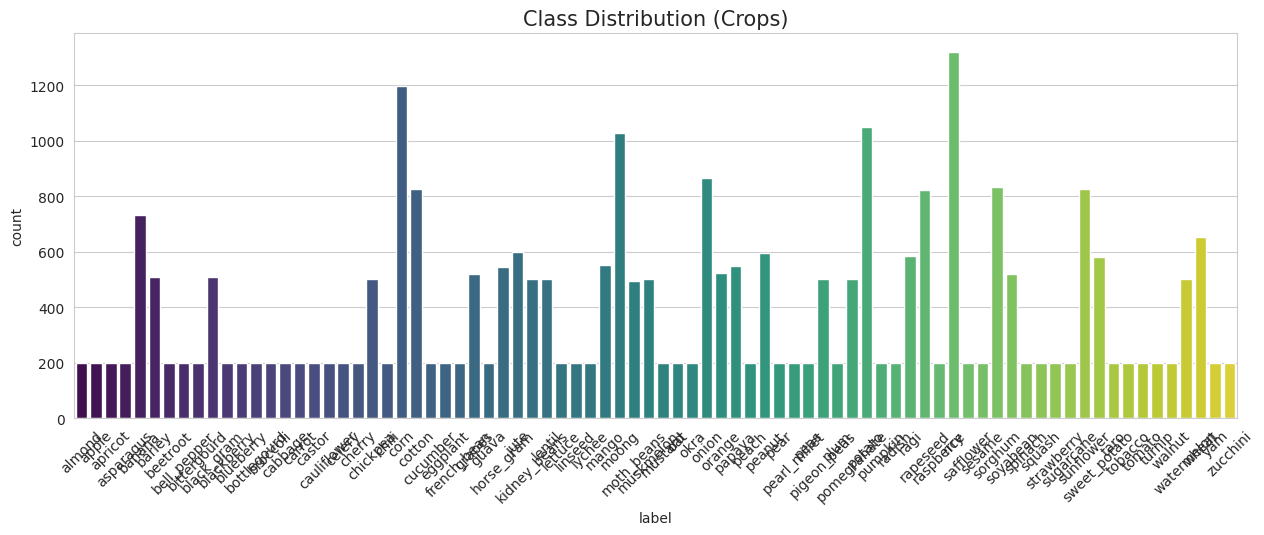

In [143]:
# Check Class Distribution
plt.figure(figsize=(15, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Class Distribution (Crops)', fontsize=15)
plt.xticks(rotation=45)
plt.show()

In [144]:
# Create a pivot table to show average conditions for each crop
crop_summary = df.groupby('label')[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']].mean()

# Display with a heatmap overlay (Gradient background)
# This makes it instantly readable for a presentation
display(crop_summary.style.background_gradient(cmap='Greens'))

,N,P,K,temperature,humidity,ph,rainfall
label,,,,,,,
almond,61.458524,35.587038,59.316192,20.098687,75.151272,6.991156,745.435210
apple,40.316630,85.088928,129.892430,20.394276,83.945939,6.213997,659.956587
apricot,59.603143,40.347384,75.733745,19.740152,74.255329,7.019110,807.931122
asparagus,60.881856,50.337275,60.067141,20.409171,75.983892,6.407357,788.657462
banana,105.335509,81.406164,97.776443,27.645420,80.623320,6.265508,694.281653
barley,66.980344,38.143773,42.224463,19.914161,80.238200,5.934258,258.565558
beetroot,65.459173,39.805962,65.925171,17.504158,73.836422,6.966609,620.505929
bell_pepper,119.111579,64.748149,92.300005,25.257867,73.777693,6.459174,802.499541
bittergourd,60.000126,10.003442,19.993297,27.133194,93.185378,6.520252,1653.639803


## 3. Data Cleaning & Preprocessing
Checking for null values, encoding labels, and visualizing feature relationships.

In [145]:
# 1. Handle Missing Values
if df.isnull().sum().sum() > 0:
    print("Missing values found. Filling with mean...")
    df = df.fillna(df.mean())
else:
    print("No missing values found.")

No missing values found.


In [146]:
# 2. Encode Target Labels
# XGBoost requires numeric labels (0, 1, 2...), so we must encode the string labels.
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print(f"\nEncoded Classes: {list(label_encoder.classes_[:5])}...")


Encoded Classes: ['almond', 'apple', 'apricot', 'asparagus', 'banana']...


In [147]:
# 3. Define Features (X) and Target (y)
X = df.drop(['label', 'label_encoded'], axis=1)
y = df['label_encoded']

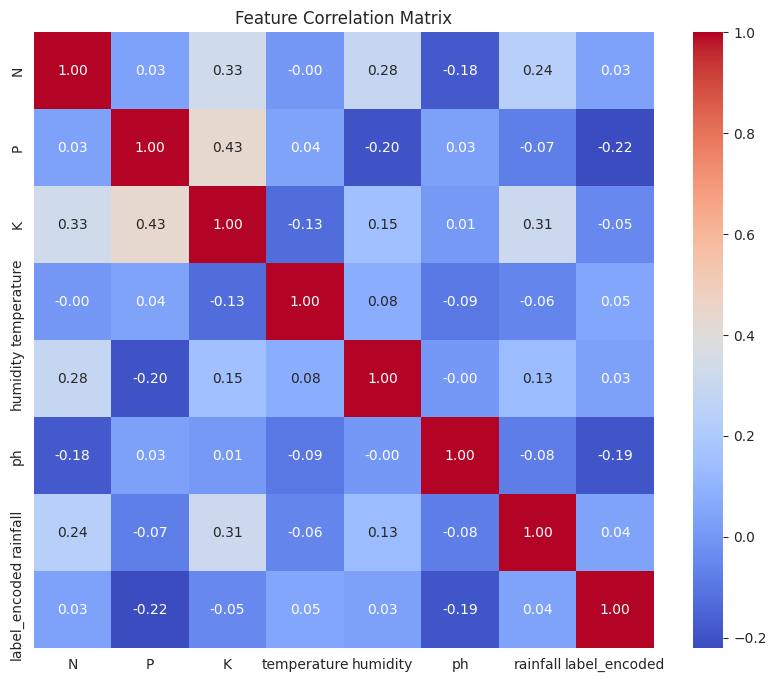

In [148]:
# 4. Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation = df.drop(['label'], axis=1).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

## 4. Train-Test Split
 We use a stratified split to maintain the ratio of crops in both training and testing sets.

In [149]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [150]:
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (24424, 7)
Testing Data Shape: (6106, 7)


## Optional: Scaling

In [151]:
# While trees are robust to unscaled data, scaling helps convergence and SHAP interpretability.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

 ## 5. Model Training & Evaluation
 We will train three models: Decision Tree, Random Forest, and XGBoost.

In [152]:
# Dictionary to store results
model_results = {}

def train_evaluate_model(model, name, X_tr, X_te, y_tr, y_te):
    print(f"--- Training {name} ---")
    model.fit(X_tr, y_tr)

    # Prediction
    y_pred = model.predict(X_te)

    # Metrics
    acc = accuracy_score(y_te, y_pred)
    print(f"Accuracy: {acc*100:.2f}%")
    print("Classification Report (First 3 classes snippet):")
    print(classification_report(y_te, y_pred, digits=4, output_dict=False)[:500] + "...\n")

    model_results[name] = acc
    return model

In [153]:
# 1. Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model = train_evaluate_model(dt_model, 'Decision Tree', X_train_scaled, X_test_scaled, y_train, y_test)

--- Training Decision Tree ---
Accuracy: 88.44%
Classification Report (First 3 classes snippet):
              precision    recall  f1-score   support

           0     0.7045    0.7750    0.7381        40
           1     0.8462    0.5500    0.6667        40
           2     0.7609    0.8750    0.8140        40
           3     0.7907    0.8500    0.8193        40
           4     1.0000    1.0000    1.0000       147
           5     0.9140    0.8416    0.8763       101
           6     0.7949    0.7750    0.7848        40
           7     0.7727    0.8500    0.8095        40
           8 ...



In [154]:
# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model = train_evaluate_model(rf_model, 'Random Forest', X_train_scaled, X_test_scaled, y_train, y_test)

--- Training Random Forest ---
Accuracy: 92.07%
Classification Report (First 3 classes snippet):
              precision    recall  f1-score   support

           0     0.8780    0.9000    0.8889        40
           1     0.9583    0.5750    0.7188        40
           2     0.9286    0.9750    0.9512        40
           3     0.8667    0.9750    0.9176        40
           4     1.0000    1.0000    1.0000       147
           5     0.9565    0.8713    0.9119       101
           6     0.8974    0.8750    0.8861        40
           7     0.8605    0.9250    0.8916        40
           8 ...



In [155]:
# 3. XGBoost
xgb_model = xgb.XGBClassifier(
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model = train_evaluate_model(xgb_model, 'XGBoost', X_train_scaled, X_test_scaled, y_train, y_test)

--- Training XGBoost ---
Accuracy: 91.07%
Classification Report (First 3 classes snippet):
              precision    recall  f1-score   support

           0     0.7083    0.8500    0.7727        40
           1     0.9200    0.5750    0.7077        40
           2     0.8864    0.9750    0.9286        40
           3     0.9024    0.9250    0.9136        40
           4     1.0000    1.0000    1.0000       147
           5     0.9444    0.8416    0.8901       101
           6     0.8750    0.8750    0.8750        40
           7     0.8298    0.9750    0.8966        40
           8 ...



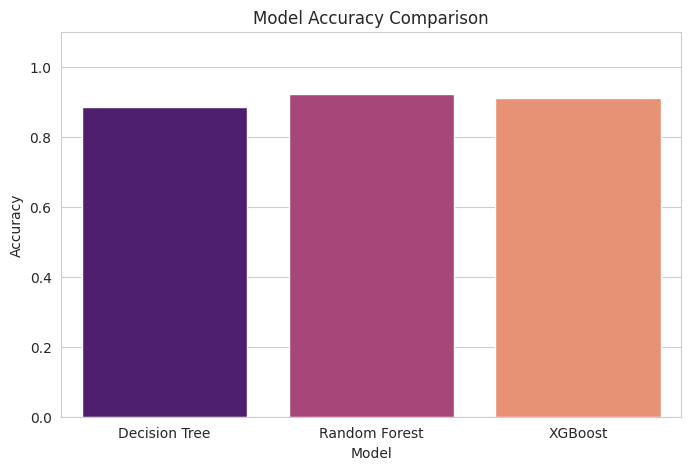

In [156]:
# Comparison
results_df = pd.DataFrame(list(model_results.items()), columns=['Model', 'Accuracy'])
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='magma')
plt.ylim(0, 1.1)
plt.title('Model Accuracy Comparison')
plt.show()

## 6. Top-K Recommendation System
 Instead of predicting just one crop, we recommend the top 3 most suitable crops with confidence scores.



In [157]:
def get_top_k_predictions(model, input_data, k=3):
    # Get probabilities for all classes
    probs = model.predict_proba(input_data)[0]

    # Get indices of top k probabilities
    top_k_indices = np.argsort(probs)[-k:][::-1]

    # Get class names and scores
    top_crops = label_encoder.inverse_transform(top_k_indices)
    top_scores = probs[top_k_indices]

    return list(zip(top_crops, top_scores))

In [158]:
# Test on a single test sample
sample_idx = 21
sample_input = X_test_scaled.iloc[[sample_idx]]
true_label = label_encoder.inverse_transform([y_test.iloc[sample_idx]])[0]

print(f"True Crop: {true_label}")
print("Top 3 Recommendations:")
recommendations = get_top_k_predictions(xgb_model, sample_input, k=3)

for crop, score in recommendations:
    print(f" - {crop}: {score*100:.2f}% confidence")

True Crop: spinach
Top 3 Recommendations:
 - spinach: 99.68% confidence
 - lettuce: 0.30% confidence
 - cherry: 0.00% confidence


 ## 7. Feature Importance
 Understanding which soil/weather factors contribute most to the decision.

<Figure size 1000x600 with 0 Axes>

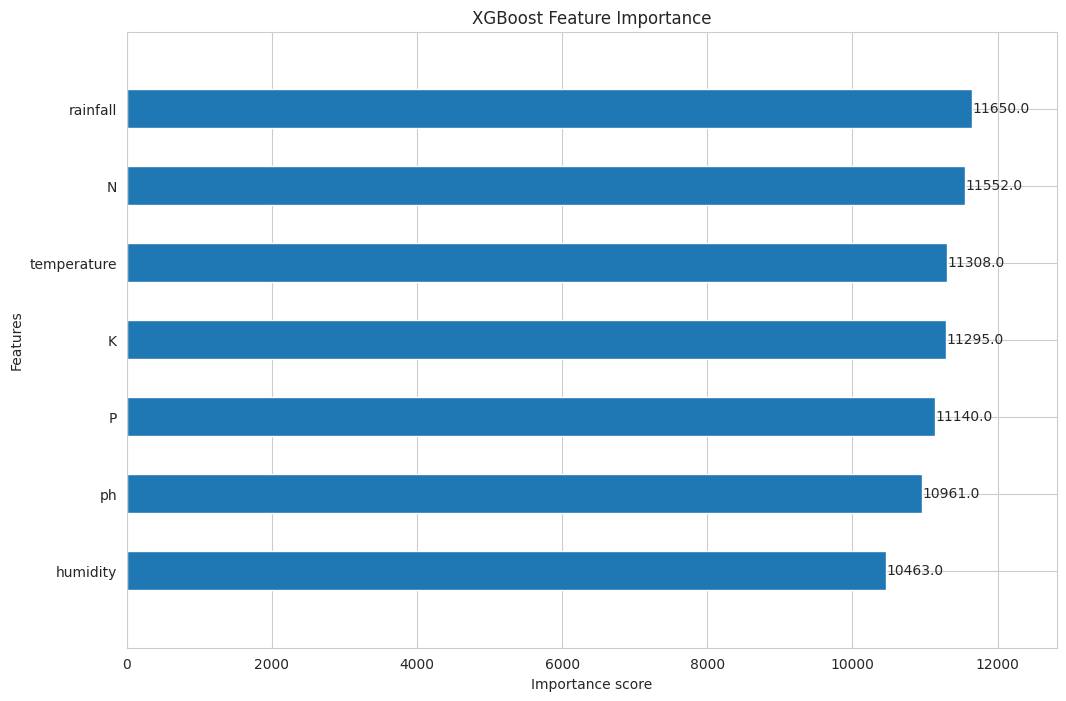

In [159]:
# XGBoost Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, height=0.5)
plt.title('XGBoost Feature Importance')
plt.show()

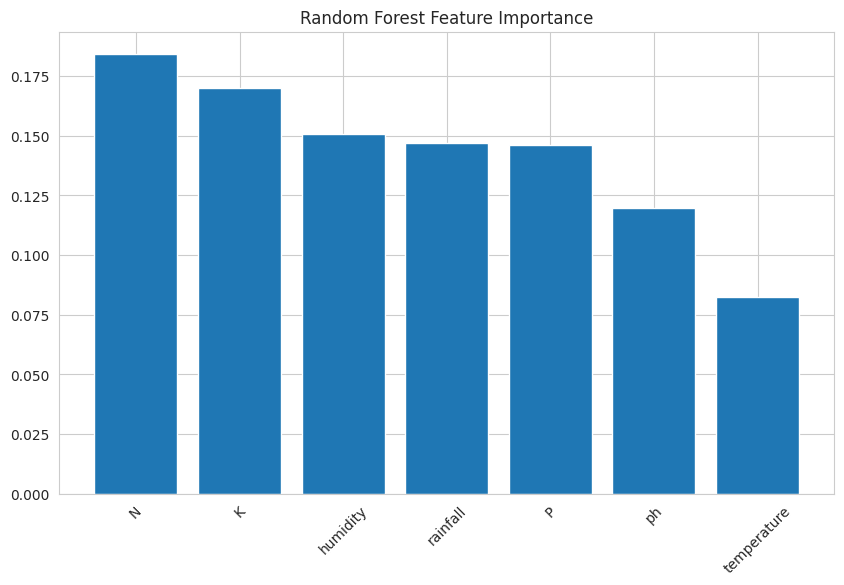

In [160]:
# Random Forest Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.show()

## 8. SHAP Explainability
Using SHAP (SHapley Additive exPlanations) to explain individual predictions.



SHAP Summary Plot (Global Interpretability):


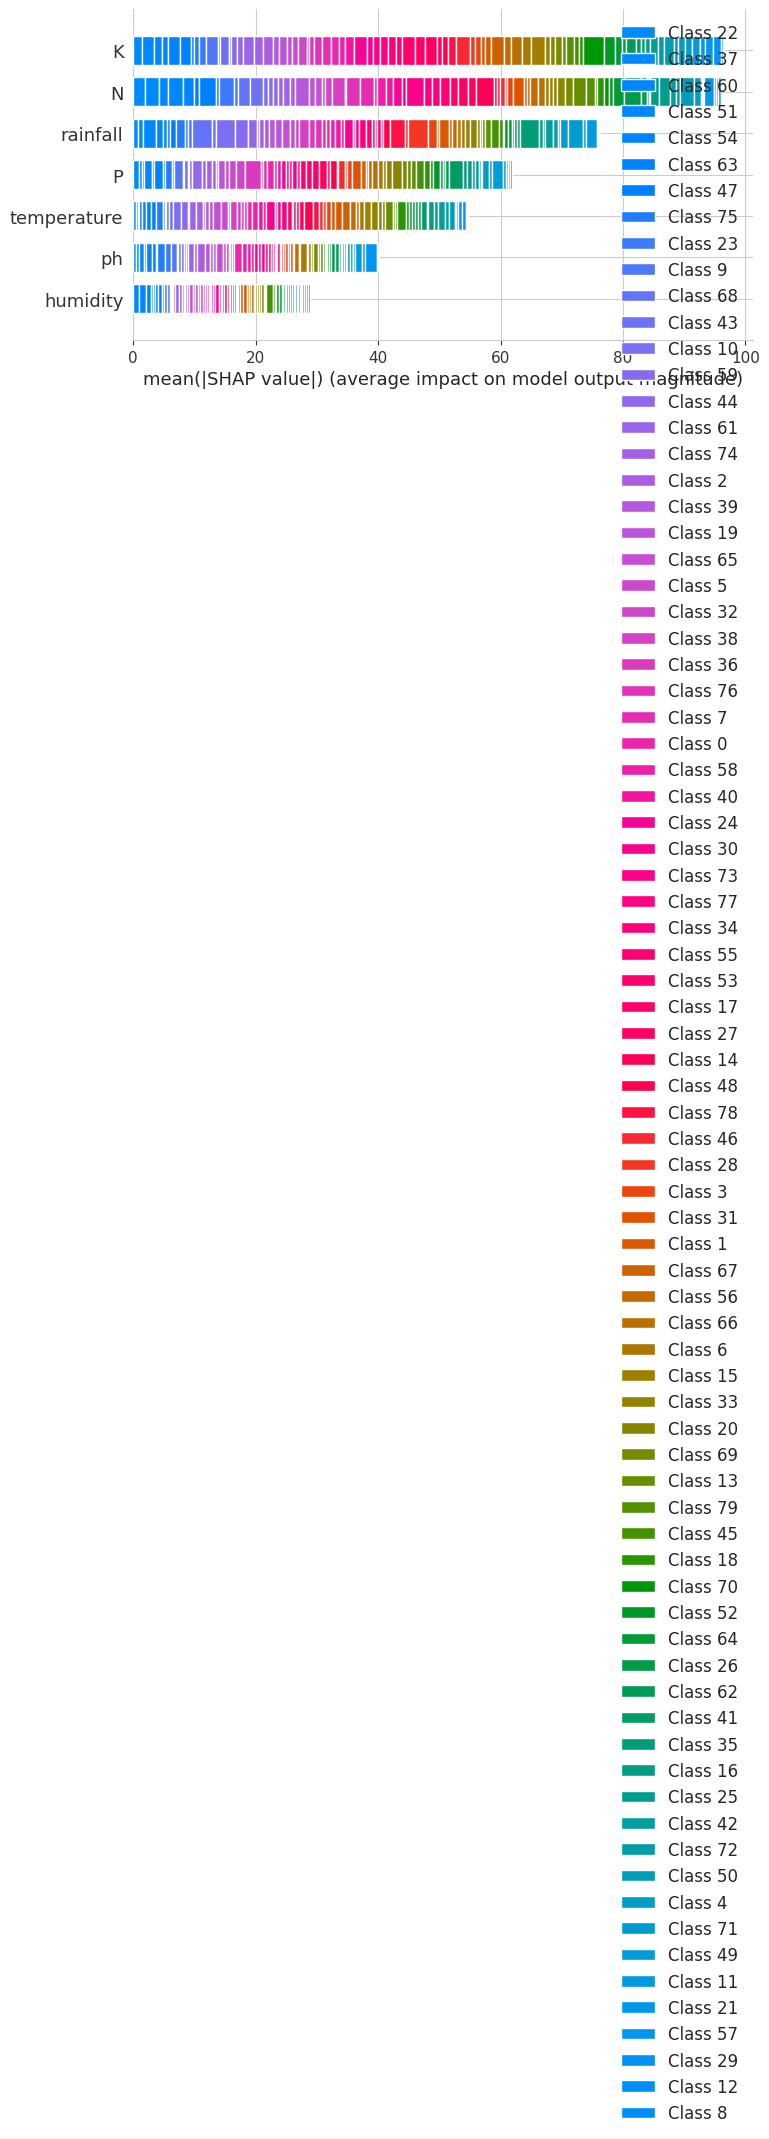

Local Explanation (Waterfall plot for single prediction):
SHAP visualization skipped due to environment limits or error: index 51 is out of bounds for axis 0 with size 7


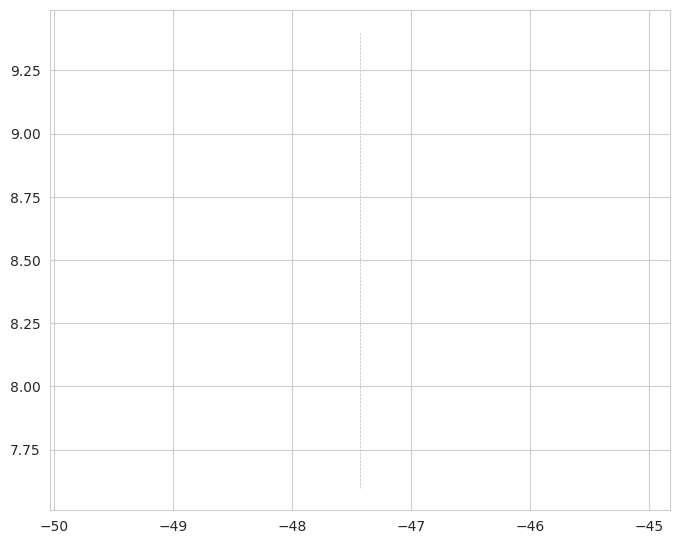

In [161]:
try:
    # Initialize JS for plots
    shap.initjs()

    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(xgb_model)

    # Calculate shap values for test set (taking a subset for speed if needed)
    shap_values = explainer.shap_values(X_test_scaled)

    print("SHAP Summary Plot (Global Interpretability):")
    # For multiclass, shap_values is a list of arrays. We plot for the predicted class of the first sample
    # or just a summary plot which might be crowded for 22 classes.
    # Let's plot the summary for class 0 as an example, or flatten if permitted.
    shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

    print("Local Explanation (Waterfall plot for single prediction):")
    # Explanation for the first item in test set
    # Note: For multiclass XGBoost, shap_values is a list. We pick the list corresponding to the predicted class.
    pred_idx = xgb_model.predict(X_test_scaled.iloc[[0]])[0]

    # Waterfall plot
    shap.plots.waterfall(shap.Explanation(values=shap_values[pred_idx][0],
                                          base_values=explainer.expected_value[pred_idx],
                                          data=X_test_scaled.iloc[0],
                                          feature_names=X.columns))

except Exception as e:
    print(f"SHAP visualization skipped due to environment limits or error: {e}")

## 9. Save the Best Model
 Saving the trained XGBoost model along with the necessary preprocessors (Scaler and LabelEncoder) is crucial for real-world deployment.



In [162]:
# Save the model
joblib.dump(xgb_model, 'crop_recommender_v1.joblib')

# Save the preprocessors (Essential for the API!)
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

print("Model and preprocessors saved successfully.")

Model and preprocessors saved successfully.


## 10. Inference Example
 Simulating a user input from the website to the backend model.

In [163]:
def predict_crop(input_data):
    """
    Accepts dictionary of raw values, scales them, and returns predictions.
    """
    # 1. Convert to DataFrame
    input_df = pd.DataFrame([input_data])

    # 2. Scale features (Must use the SAME scaler trained above)
    input_scaled = pd.DataFrame(scaler.transform(input_df), columns=input_df.columns)

    # 3. Predict Top 3
    recommendations = get_top_k_predictions(xgb_model, input_scaled, k=3)

    return recommendations



In [164]:
# Manual Input Sample (High Nitrogen, High Rainfall - likely Rice or Jute?)
sample_user_input = {
    "N": 90,
    "P": 42,
    "K": 43,
    "temperature": 25,
    "humidity": 80, # High humidity
    "ph": 6.5,
    "rainfall": 200 # Heavy rain
}

print(f"User Input: {sample_user_input}\n")
results = predict_crop(sample_user_input)

print("--- SCAS Recommendations ---")
for rank, (crop, conf) in enumerate(results, 1):
    print(f"{rank}. {crop.upper()} ({conf*100:.1f}% Confidence)")

User Input: {'N': 90, 'P': 42, 'K': 43, 'temperature': 25, 'humidity': 80, 'ph': 6.5, 'rainfall': 200}

--- SCAS Recommendations ---
1. RICE (89.7% Confidence)
2. JUTE (8.2% Confidence)
3. SOYABEAN (0.5% Confidence)
